In [328]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.xkcd()
import quandl
import pandas as pd
import numpy as np
import functools
import statistics
import math
import os
from datetime import datetime

import scipy as sp
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
pd.options.mode.chained_assignment = None

Arjun Kilaru

Homework 2

Quantitative Trading Strategies

In [ ]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="v2EVM2mpJPBQrcyFbxcH", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )


In [11]:
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key="v2EVM2mpJPBQrcyFbxcH")
    return qdata

def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [ ]:
RING = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'RING',date = { 'gte': '2020-12-02', 'lte': '2022-11-22' }, paginate=True)
RING['date'] = pd.to_datetime(RING['date'])
RING = RING.set_index('date')
RING = RING.iloc[::-1]
RING.head()

In [312]:
GDX = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'GDX',date = { 'gte': '2020-12-02', 'lte': '2022-11-22' }, paginate=True)
GDX['date'] = pd.to_datetime(GDX['date'])
GDX = GDX.set_index('date')
GDX = GDX.iloc[::-1]
GDX.head()

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2020-12-02,GDX,35.97,36.10,35.520,35.97,23716488.0,0.0,1.0,35.168222,35.295324,34.728252,35.168222,23716488.0
2020-12-03,GDX,36.14,36.14,35.235,35.51,21086514.0,0.0,1.0,35.334432,35.334432,34.449605,34.718475,21086514.0
2020-12-04,GDX,35.50,35.81,35.060,35.31,15642110.0,0.0,1.0,34.708698,35.011788,34.278506,34.522933,15642110.0
2020-12-07,GDX,35.30,36.92,35.240,36.50,26560182.0,0.0,1.0,34.513156,36.097046,34.454493,35.686408,26560182.0
2020-12-08,GDX,36.66,36.75,36.230,36.35,15020976.0,0.0,1.0,35.842841,35.930835,35.422426,35.539751,15020976.0


In [371]:
data = pd.DataFrame()
data['RING_volume'] = RING['adj_volume']
data['RING_close'] = RING['adj_close']
data['GDX_volume'] = GDX['adj_volume']
data['GDX_close'] = GDX['adj_close']
data.index = GDX.index
data['dollar_volume'] = data['RING_volume'] * data['RING_close']
data['Nt'] = data['dollar_volume'].rolling(window=15, center=False, min_periods = 15).median()
data['Nt'].head(30)
data

,RING_volume,RING_close,GDX_volume,GDX_close,dollar_volume,Nt
date,,,,,,
2020-12-02,243874.0,28.264378,23716488.0,35.168222,6.892947e+06,NaN
2020-12-03,102642.0,27.969263,21086514.0,34.718475,2.870821e+06,NaN
2020-12-04,900411.0,27.797906,15642110.0,34.522933,2.502954e+07,NaN
2020-12-07,205666.0,28.816528,26560182.0,35.686408,5.926580e+06,NaN
2020-12-08,70002.0,28.721330,15020976.0,35.539751,2.010551e+06,NaN
...,...,...,...,...,...,...
2022-11-16,197420.0,20.830822,15675126.0,27.530000,4.112421e+06,1.725048e+06
2022-11-17,230936.0,20.445615,24623307.0,27.120000,4.721628e+06,1.747854e+06
2022-11-18,82012.0,20.563152,28555806.0,27.370000,1.686425e+06,1.747854e+06


In [ ]:
def trading_strategy(df, j, g, M, s):
    
    starting_capital = max(data['Nt'].dropna())*2
    
    in_pos = False #boolean to check if we are in a positition or not
    month_reset = False #boolean to check if we are in a reset period (triggered by a stop loss)
    
    df['RING_return'] = df['RING_close'].pct_change(periods = M) #5 
    df['GDX_return'] = df['GDX_close'].pct_change(periods = M) #6
    
    df['s'] = df['RING_return'] - df['GDX_return'] #7 #The spread
    index = df.index.get_loc('2021-01-04')
    df = df.iloc[index:]
    df = df.drop('dollar_volume', axis = 1)
    position = [0,0]
    df['PnL'] = 0 #8
    df['position_RING'] = 0 #9
    df['position_GDX'] = 0 #10
 
    for i in range(len(df)):
        
        trade_size = round((df.iloc[i, 4] * 0.01),1)
        #set the trade size
        
        
        
        if in_pos:
            df.iloc[i,9] = df.iloc[i-1,9]
            df.iloc[i,10] = df.iloc[i-1,10] #updates the position for the next row if in position
    
        if in_pos:
            present_position_value = df.iloc[i,1]*position[0] + df.iloc[i,3]*position[1] #sets up the stop loss parameter
            if present_position_value * -1 > s*gross_traded_cash:
                #print("STOP LOSS AT " + str(df.index[i]))
                in_pos = False
                month_reset = True
                position = [0,0]
                df.iloc[i,9] = 0
                df.iloc[i,10] = 0
        if i > 0 and df.index[i].month != df.index[i-1].month:
     #       print("MONTH EXIT AT " + str(df.index[i])) 
            in_pos = False
            month_reset = False
            position = [0,0]
            df.iloc[i,9] = 0
            df.iloc[i,10] = 0
        if position == [0,0] and month_reset == False:
            if df.iloc[i,7] > j+g:
                #short the spread
        #        print("SHORT ENTER AT " + str(df.index[i])) 
                in_pos = True
                position[0] = (-1*trade_size)/df.iloc[i,1]
                position[1] = trade_size/df.iloc[i,3]
                df.iloc[i,9] = position[0]
                df.iloc[i,10] = position[1]
                gross_traded_cash = 2*trade_size
            if df.iloc[i,7] < j-g:
                #long the spread
        #        print("LONG ENTER AT " + str(df.index[i])) 
                in_pos = True
                position[0] = trade_size/df.iloc[i,1]
                position[1] = (-1*trade_size)/df.iloc[i,3]
                df.iloc[i,9] = position[0]
                df.iloc[i,10] = position[1]
                gross_traded_cash = 2*trade_size

        if df.iloc[i, 7] < j and df.iloc[i, 7] > -1*g and in_pos:
            #print("EXIT AT " + str(df.index[i])) 
            in_pos = False
            position = [0,0]
            df.iloc[i,9] = 0
            df.iloc[i,10] = 0
        if i == 0:
            df.iloc[i,8] = df.iloc[i,9]*df.iloc[i,1] + df.iloc[i,10]*df.iloc[i,3]
        if i > 0:
            df.iloc[i,8] = df.iloc[i,9]*df.iloc[i,1] + df.iloc[i,10]*df.iloc[i,3] - df.iloc[i,8]


    cum_pnl = []
    for i in range(1,len(df)):
        if df.iloc[i-1,8] != 0 and df.iloc[i,8] == 0:
            cum_pnl.append(df.iloc[i-1,8])
            continue
        cum_pnl.append(0)
    cum_pnl.append(0)
    df['cum_pnl'] = cum_pnl
    df['cum_pnl'] = df['cum_pnl'].cumsum()
    final_return = (df.iloc[len(df)-1, 11])/starting_capital
  #  print("FINAL RETURN: " + str(final_return) + "%")
    return (df, final_return)

strategy = trading_strategy(data, -0.01, 0.01, 10, 0.1)[0]
strategy.tail(60)

We will try and see how our trading strategy performs based upon some values of j,g,s, and M that we choose.

Logically, it makes sense to set j as the mean of the spread and g as different quantiles or standard deviations of the spread. 

In [373]:
strategy.describe()

,RING_volume,RING_close,GDX_volume,GDX_close,Nt,RING_return,GDX_return,s,PnL,position_RING,position_GDX,cum_pnl
count,4.770000e+02,477.000000,4.770000e+02,477.000000,4.770000e+02,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000
mean,1.486533e+05,25.401733,2.309335e+07,31.687859,2.895351e+06,-0.004673,-0.003179,-0.001494,13.253562,-331.923459,270.617566,980.409701
std,1.598189e+05,3.764309,8.921561e+06,4.220214,1.169365e+06,0.063915,0.064309,0.010045,83.644533,655.576803,528.792110,253.880459
min,2.369200e+04,16.850347,9.250773e+06,21.860000,1.001292e+06,-0.156080,-0.154637,-0.050528,-598.426007,-1514.554373,-1909.182934,0.000000
25%,7.020500e+04,23.899945,1.684123e+07,29.680000,2.070395e+06,-0.053022,-0.050420,-0.005970,0.000000,-1005.360531,0.000000,897.262179
50%,1.053260e+05,25.909318,2.109972e+07,31.980000,2.795326e+06,-0.005971,-0.002798,-0.001164,0.000000,0.000000,0.000000,966.222803
75%,1.678750e+05,27.747654,2.793806e+07,34.240000,3.541869e+06,0.038382,0.041751,0.004540,0.000000,0.000000,822.336694,1148.438405
max,1.745361e+06,32.353849,8.026973e+07,40.870000,7.615498e+06,0.202091,0.195767,0.024965,516.337844,2415.662006,1243.229747,1262.355182


The mean of the spread is -0.001494 and the standard deviation is 0.010045. Let's see how our returns are when we employ these parameters.

In [374]:
trading_strategy(data, -0.001494, 0.010045, 10, 0.1)[1]

-0.00012338670188296694

Surprisingly, we get a negative overall return. After inspecting the data, I suspect this may have to do with the forced liquidation of positions at the end of the month. Often times, the spread is at a state of negative PnL at the end of the month, and the forced liquidation results in realized losses. Let's try two standard deviations now. 

In [380]:
trading_strategy(data, -0.001494, 2*0.010045, 10, 0.1)[1]
trading_strategy(data, -0.001494, 3*0.010045, 10, 0.1)[1]
trading_strategy(data, -0.001494, 4*0.010045, 10, 0.1)[1]

7.984909238317102e-06

The overall returns are still negative when we make our 'g' two standard deviations, but only slightly. The same is the case when g is 3 standard deviations. When g is 4 standard deviations, the return is slightly positive.

Using one standard deviation above j as the benchmark g, let's graph different returns based upon values of j. Afterwards we will do the same for M.

In [407]:
plots = pd.DataFrame()
js = []
returns = []
for i in np.arange(-0.050,0.025,0.0025):
    js.append(i)
    returns.append(trading_strategy(data, i, i + 0.010045, 10, 0.1)[1])

plots.index = js
plots['jsreturns'] = returns    

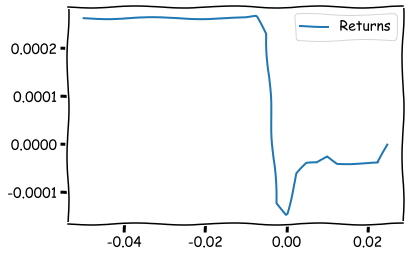

In [411]:
fig, ax = plt.subplots()
ax.plot(plots['jsreturns'])
ax.legend(['Returns'])

We get a maximum return of 0.000266 when we set the value of "j" to -0.0075, which is relatively close to the mean. but within one standard deviation.

Now, using the mean as the constant j (for now), we will try and find the maximum g.

In [416]:
plots = pd.DataFrame()
gs = []
returns = []
for i in np.arange(0,0.05,0.0025):
    gs.append(i)
    returns.append(trading_strategy(data, -0.01, -0.01 + i, 10, 0.1)[1])

plots.index = gs
plots['gsreturns'] = returns 


,gsreturns
0.0000,0.000237
0.0025,0.000250
0.0050,0.000232
0.0075,0.000282
0.0100,0.000263
0.0125,0.000215
0.0150,0.000216
0.0175,0.000219
0.0200,0.000228
0.0225,0.000112


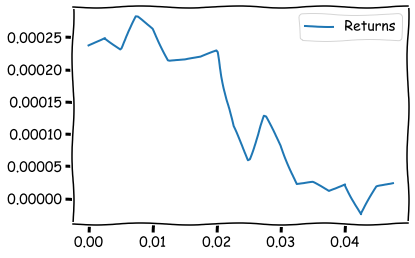

In [417]:
fig, ax = plt.subplots()
ax.plot(plots['gsreturns'])
ax.legend(['Returns'])
plots

We get a maximum return here of 0.000282. That occurs when we set "g" to 0.0075. 

Lastly, we will see if any values of M affect the returns. We will use our base returns as j = 0.01 and g = 0.0075, as that has produced the highest returns for us so far.

In [429]:
plots = pd.DataFrame()
ms = []
returns = []
for i in range(0,30):
    ms.append(i)
    returns.append(trading_strategy(data, -0.01, -0.01 + 0.0075, i, 0.1)[1])

plots.index = ms
plots['msreturns'] = returns 


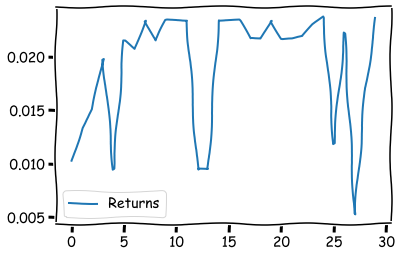

In [430]:
fig, ax = plt.subplots()
ax.plot(plots['msreturns'])
ax.legend(['Returns'])

We achieve our peak returns of 0.00303 when we set M = 24. 

Lastly, we will check if changing our stop loss parameter affects anything. 

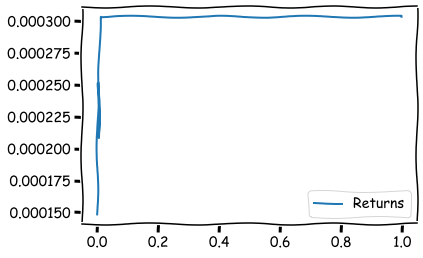

In [480]:
plots = pd.DataFrame()
ss = []
returns = []
for i in np.arange(0,1,0.0025):
    ss.append(i)
    returns.append(trading_strategy(data, -0.01, -0.01 + 0.0075, 24, i)[1])

plots.index = ss
plots['ssreturns'] = returns 
fig, ax = plt.subplots()
ax.plot(plots['ssreturns'])
ax.legend(['Returns'])

It seems as though our strategy was not improved by changing the stop loss parameter. Ultimately, by choosing parameters somewhat close to the spread mean and standard deviation and running stepwise optimization loops, we arrived at a maximum return of around 0.0003. 

Now, we will see the correlations with the Fama French Returns.

In [ ]:
fama = pd.read_csv("Developed_3_Factors_Daily.csv")
dates = fama['DATE']
for i in range(len(fama)):
    date_string = str(dates[i])
    dates[i]= datetime.strptime(date_string, "%Y%m%d")

fama.index = dates
fama = fama.loc['2021-01-04':]
fama = fama.loc[:'2022-11-22']
data_cor = trading_strategy(data, -0.01, 0.0075, 24, 0.1)[0]
merged_df = pd.merge(fama, data_cor, left_index=True, right_index=True, how='outer', indicator=True)
merged_df = merged_df.dropna()
merged_df

Now, we calculate the correlations with the Fama French factors

In [464]:
merged_df['SMB'].corr(merged_df['cum_pnl'])
merged_df['HML'].corr(merged_df['cum_pnl'])
merged_df['RF'].corr(merged_df['cum_pnl'])
merged_df['Mkt-RF'].corr(merged_df['cum_pnl'])

-0.05111098535681795

Correlation of cumulative PnL with SMB is 0.006166224893262322. Correlation with HML is -0.020787490768471372.
Correlation with RF is 0.25141652101096995. Correlation with Mkt-RF is -0.05111098535681795. 

As expected, there is not any significant correlation between the cumulative PnL of the strategy and the Fama-French factors, which means that our strategy is relatively market-neutral.